# RNN (LSTM)

The second approach was based on an Recurrent Neural Network containing LSTM cells.

In [1]:
%load_ext tensorboard

In [12]:
import tensorflow as tf
from preprocessing.categorical import binarizer
from pandas import read_parquet
from data import file
from models import rnn
import json

In [1]:

physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

2021-11-23 06:05:25.514661: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 06:05:25.541336: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 06:05:25.541969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [2]:
data_train = read_parquet(file.news_articles_cleaned_train)
data_test = read_parquet(file.news_articles_cleaned_test)

In [3]:

X_train = data_train.text_tokenized_stemmed
y_train = data_train.label

X_test = data_test.text_tokenized_stemmed
y_test = data_test.label



batch_size = 32

y_train = data_train.label
label_binarizer = binarizer(y_train)

x_train = data_train['text_stem']
y_train_bin = label_binarizer.transform(y_train)

x_test = data_test['text_stem']
y_test_bin = label_binarizer.transform(y_test)

train_input = tf.data.Dataset.from_tensor_slices((x_train, y_train_bin)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_input = tf.data.Dataset.from_tensor_slices((x_test, y_test_bin)).batch(batch_size).prefetch(tf.data.AUTOTUNE)
train_input


2021-11-23 06:05:27.747180: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-11-23 06:05:27.747954: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 06:05:27.748672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-23 06:05:27.749240: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

<PrefetchDataset shapes: ((None,), (None, 9)), types: (tf.string, tf.int64)>

In [4]:
model, model_name = rnn.build_model(X_train, y_train, len(label_binarizer.classes_), rnn_num_layers = 1)
model.summary()

Median sequence length:       : 171
Percentil                     : 0.98)
Cutoff sequence length        : 588
Max sequence length           : 2590
Embedding length              : 588
Vocabulary length             : 139291


Model: "rnn"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization (TextVect (None, None)              0         
_________________________________________________________________
embedding (Embedding)        (None, None, 300)         41787300  
_________________________________________________________________
bidirectional_lstm_0 (Bidire (None, None, 64)          85248     
_________________________________________________________________
global_max_pool (GlobalMaxPo (None, 64)                0         
_________________________________________________________________
prediction (Dense)           (None, 9)                 585       
Total params: 41,873,133
Trainable params: 85,833
Non-trainable params: 41,787,300
_________________________________________________________________


In [5]:
from keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam

learning_rate=0.02
model_metric = ["accuracy"]
loss_function = CategoricalCrossentropy()
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss=loss_function, optimizer=optimizer, metrics=model_metric)

In [6]:
callbacks = []
history = model.fit(train_input, validation_data=test_input, callbacks=callbacks, epochs=5)

Epoch 1/5


2021-11-23 06:06:39.764128: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-23 06:06:41.446175: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


226/226 [==============================] - 57s 215ms/step - loss: 1.6908 - accuracy: 0.4060 - val_loss: 1.4112 - val_accuracy: 0.5063
Epoch 2/5
226/226 [==============================] - 45s 201ms/step - loss: 1.2800 - accuracy: 0.5655 - val_loss: 1.2375 - val_accuracy: 0.5757
Epoch 3/5
226/226 [==============================] - 46s 202ms/step - loss: 1.0615 - accuracy: 0.6415 - val_loss: 1.1814 - val_accuracy: 0.5873
Epoch 4/5
226/226 [==============================] - 46s 202ms/step - loss: 0.8881 - accuracy: 0.6965 - val_loss: 1.1948 - val_accuracy: 0.6028
Epoch 5/5
226/226 [==============================] - 45s 201ms/step - loss: 0.7368 - accuracy: 0.7529 - val_loss: 1.2216 - val_accuracy: 0.5999


## Evaluation

In [9]:
count = 100
expected = y_test[0:100]
predicted = label_binarizer.inverse_transform(model.predict(x_test[0:100]))

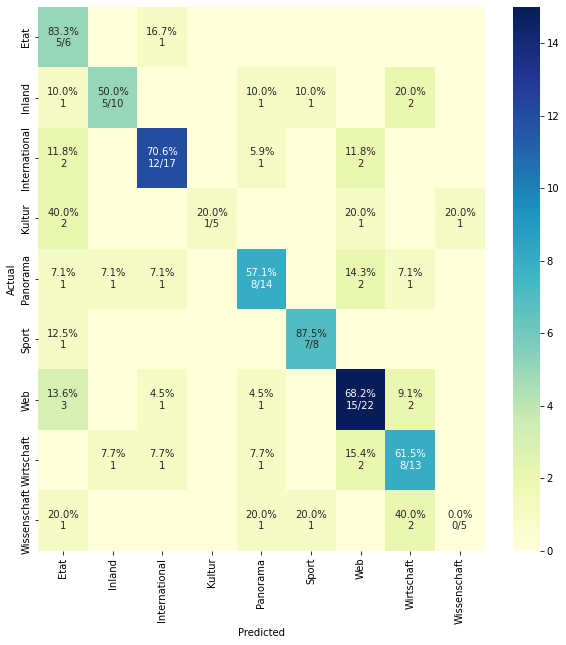

In [10]:
from reporting.evaluation import plot_confusion_matrix
plot_confusion_matrix(expected, predicted)

In [15]:
reporting_data = {
    "expected": expected.tolist(),
    "predicted": predicted.tolist(),
}
with open(file.reporting_data_report_rnn, 'w') as f:
    json.dump(reporting_data, f)